In [2]:
import os
import pandas as pd

# 定义清理函数，用于清理 Excel 文件中的空格和无用列
def clear():
    # 遍历指定文件夹下的所有xlsx文件
    folder_path = 'D:\\ML-all\\IrelandFungicideDataAnalysis\\data_IR' # 请替换为你的文件夹路径
    for filename in os.listdir(folder_path): # os.listdir()函数是读取文件夹中子目录的名称的函数
        if filename.endswith(".xlsx"):
            
            file_path = os.path.join(folder_path, filename)# 子目录将字符串添加到folder_path中，形成完整的文件路径
            # 使用pandas读取xlsx文件
            df = pd.read_excel(file_path)

            # 删除第一列字符串中的空格
            df[df.columns[0]] = df[df.columns[0]].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)
            ## 眼神不好，这个replace(' ', '')中间的逗号是分隔符
            ## lambda 函数是匿名函数。用于在一行内实现一个简单的函数
            ## apply 方法可以对df数据进行自定义函数处理，是数据转换工具
            
            # 删除第一行字符串中的空格
            df.columns = df.columns.to_series().apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)
            ## Pandas 提供了 columns 属性，它返回一个 Index 对象。这个 Index 对象包含了 DataFrame 的列名，但并不是直接的 Series 对象。
            ## 所以左侧是列名，右侧是对列名进行的函数运算
            ## 注意区分列和列名

            # 将 DataFrame 的第一列与其余列连接，并且只包括那些列名不以 'Unnamed' 开头的列
            df = df[df.columns[0]].to_frame().join(df.loc[:, ~df.columns.str.startswith('Unnamed')])
            ## df.loc[row_label, column_label]函数让我们自由选择行和列，其中，row_label 是行的标签，可以是单个标签、标签的列表，或者切片；
            ## column_label 是列的标签，可以是单个标签、标签的列表，或者切片
            # .to_frame()：将所选列转换为 DataFrame。to_frame() 方法用于将 Series 转换为 DataFrame
            ## ~df.columns.str.startswith('Unnamed')表示那些不以“Unnamed"开头的列，~表示逻辑取反
            
            # 把第一列的列名设置为空白
            # 相当于把最左上角的单元格弄成空白
            df.rename(columns={df.columns[0]: ''}, inplace=True)

            # 重新保存xlsx文件，这将自动将所有列的宽度设为单列
            ## 注意这里只是重新保存，并没有产生新的文件
            df.to_excel(file_path, index=False)

# 定义转换函数，用于将多个 Excel 文件转换为一个 DataFrame，并将数据写入新的 Excel 文件
def trans():
    # 获取当前工作目录
    folder_path = 'D:\\ML-all\\IrelandFungicideDataAnalysis\\data_IR'
    ## getcwd()函数用来获取当前工作目录(current working directory)

    # 定义要写入的新Excel文件的路径
    output_path = os.path.join(os.getcwd(), 'output/resultIR.xlsx')

    # 定义要写入的DataFrame
    data = pd.DataFrame(columns=['Year', 'Crop Type', 'Crop', 'Fungicide', 'Hectares', 'Active Substance'])

    data1 = []
    data2 = []

    # 遍历文件夹中的所有Excel文件
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.xlsx'):
            # 解析文件名以获取年份、作物类型和表类型
            parts = file_name.split('_')
            year = parts[-2]
            crop_type = '_'.join(parts[0:-2])
            table_type = parts[-1].split('.')[0]
            
            # 读取Excel文件
            df = pd.read_excel(os.path.join(folder_path, file_name), header=0, index_col=0)
            ## header=0 表示将 Excel 文件中的第一行作为列标题。这是常见的设置，因为通常第一行包含列的名称。
            ## index_col=0 表示将 Excel 文件中的第一列作为 DataFrame 的索引列。这使得第一列中的数据成为行的标签。
            ## os.path.join是用来构建文件名的函数

            # 将数据转换为只有三列的DataFrame
            for fungicide in df.index:
                for crop in df.columns:
                    value = str(df.loc[fungicide, crop])

                    if isinstance(value, str):
                        value = value.replace(',', '').split(".")[0].replace('<', '0.')  # use 0.1 instead of <1
                        try:
                            value = float(value)
                        except ValueError:
                            value = 0.0
                    else:
                        print(value)
                        break

                    if pd.notna(value):
                        if table_type == 'ha':
                            #data1 = pd.concat([data, pd.DataFrame({'Year': year, 'Crop Type': crop_type, 'Crop': crop, 'Fungicide': fungicide, 'Hectares': value}, index=[0])], ignore_index=True)
                            data1.append([year, crop_type, crop, fungicide, value])
    
                        elif table_type == 'ac':
                            #data2 = pd.concat([data, pd.DataFrame({'Year': year, 'Crop Type': crop_type, 'Crop': crop, 'Fungicide': fungicide, 'Active Substance': value}, index=[0])], ignore_index=True)
                            data2.append([year, crop_type, crop, fungicide, value])
    
    # 将data1和data2转换为DataFrame对象
    df_data1 = pd.DataFrame(data1, columns=['Year', 'Crop Type', 'Crop', 'Fungicide', 'Hectares'])
 
    
    df_data2 = pd.DataFrame(data2, columns=['Year', 'Crop Type', 'Crop', 'Fungicide', 'Active Substance']) 
 
 
    # 使用inner方法合并df_data1和df_data2，并查找重复行
    df_data = pd.merge(df_data1, df_data2, how='inner', on=['Year', 'Crop Type', 'Crop', 'Fungicide'])
 
    # 将数据写入新的Excel文件
    
    df_data.to_excel(output_path, index=False)

    # 这行代码纠正了很久才弄清楚的，to_excel函数的用法有一定的局限性，第一个参数的类型有严格的要求
    ## 最后发现是函数getcwd()的锅，导致文件路径一直错误
    

# 调用清理函数和转换函数
clear()
trans()

In [4]:
import pandas as pd

df=pd.read_excel(os.path.join('D:\\ML-all\\IrelandFungicideDataAnalysis\\temp_data_IR', 'output/resultIR.xlsx'))

df.head()

,Year,Crop Type,Crop,Fungicide,Hectares,Active Substance
0,2000,Arable_crops,Springbarley,Azoxystrobin,2731.0,449.0
1,2000,Arable_crops,Undersownbarley,Azoxystrobin,0.0,0.0
2,2000,Arable_crops,Winterbarley,Azoxystrobin,1946.0,353.0
3,2000,Arable_crops,Springwheat,Azoxystrobin,166.0,31.0
4,2000,Arable_crops,Winterwheat,Azoxystrobin,3861.0,621.0


In [5]:


df.dropna(subset=['Fungicide'], inplace=True)
# 统计删除前的数据数量
print(f'删除前的数据数量：{len(df)}')

df.loc[df['Fungicide'].str.contains('other Fungicide', case=False), 'Fungicide'] = 'Other Fungicide'
df.loc[df['Fungicide'].str.contains('all Fungicide', case=False), 'Fungicide'] = 'all Fungicide'
df.loc[df['Fungicide'].str.contains('otherFungicide', case=False), 'Fungicide'] = 'Other Fungicide'
df.loc[df['Fungicide'].str.contains('allFungicide', case=False), 'Fungicide'] = 'all Fungicide'

df.loc[df['Fungicide'].str.contains('allFungicide', case=False), 'Fungicide'] = 'all Fungicide'
df.loc[df['Fungicide'].str.contains('allFungicide', case=False), 'Fungicide'] = 'all Fungicide'

# 删除Fugicide列中包含'all Fungicide'和'Other Fungicide'的行
df = df[~df['Fungicide'].str.contains('all Fungicide|Other Fungicide|allFungicide|OtherFungicide|all Fungicides|Other Fungicides|allFungicides|OtherFungicides', case=False)]

# 删除Crop列中包含'Allcrops'、'Totalquantity(kg)'和'Totalarea(spha)'的行
df = df[~df['Crop'].str.contains('Allcrops|Allcrops\\(spha\\)|Allcrops\\(kg\\)|Totalquantity\\(kg\\)|Totalarea\\(spha\\)|Totalquantity|Totalarea', case=False, regex=True)]
# 用了位操作符进行取反操作
# 统计删除后的数据数量
print(f'删除后的数据数量：{len(df)}')

删除前的数据数量：14109
删除后的数据数量：12917


In [6]:
df['Crop Type'].unique()
# .unique() 是一个用于获取 Series 或 DataFrame 列中唯一值的方法
print(df['Crop Type'].unique())

['Arable_crops' 'Arable_Crops' 'Edible_protected_crops'
 'Grassland_fodder_crops' 'Grassland_Fodder_crops'
 'Outdoor_vegetable_crops' 'Soft_fruit_crops' 'Soft_Fruit_Crops'
 'Top_fruit_crops' 'Top_Fruit_crops' 'Vegetable_crops']


In [7]:
# 将名称包含Arable的值重命名为Arable_crops
df.loc[df['Crop Type'].str.contains('Arable', case=False), 'Crop Type'] = 'Arable_crops'
df.loc[df['Crop Type'].str.contains('Grassland|Grassl', case=False), 'Crop Type'] = 'Grassland_fodder_crops'
df.loc[df['Crop Type'].str.contains('Protected', case=False), 'Crop Type'] = 'Protected_crops' 
df.loc[df['Crop Type'].str.contains('Soft', case=False), 'Crop Type'] = 'Soft_fruit'
df.loc[df['Crop Type'].str.contains('Top', case=False), 'Crop Type'] = 'Top_soft_fruit'
df.loc[df['Crop Type'].str.contains('vegetable', case=False), 'Crop Type'] = 'Outdoor_vegetable_crops'
df['Crop Type'].unique()

array(['Arable_crops', 'Protected_crops', 'Grassland_fodder_crops',
       'Outdoor_vegetable_crops', 'Soft_fruit', 'Top_soft_fruit'],
      dtype=object)

In [8]:
# 按照不同的值，将data分成不同的数据集
data1=df[df["Crop Type"]=="Arable_crops"].to_excel("temp_data_IR/Arable_crops.xlsx") 
data2=df[df["Crop Type"]=="Protected_crops"].to_excel("temp_data_IR/Protected_crops.xlsx")
data3=df[df["Crop Type"]=="Grassland_fodder_crops"].to_excel("temp_data_IR/Grassland_fodder_crops.xlsx")
data4=df[df["Crop Type"]=="Outdoor_vegetable_crops"].to_excel("temp_data_IR/Outdoor_vegetable_crops.xlsx")   
data8=df[df["Crop Type"]=="Top_soft_fruit"].to_excel("temp_data_IR/Top_soft_fruit.xlsx")
data9=df[df["Crop Type"]=="Soft_fruit"].to_excel("temp_data_IR/Soft_fruit.xlsx") 

[2000 2002 2004 2006 2008 2010 2012 2014 2016 2018 2020 2015 2017 2019
 2021 2003 2005 2009 2013 2007 2011]
['Arable_crops' 'Protected_crops' 'Grassland_fodder_crops'
 'Outdoor_vegetable_crops' 'Soft_fruit' 'Top_soft_fruit']


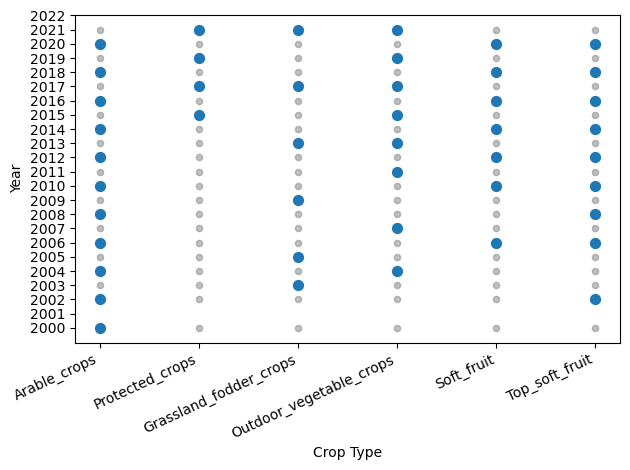

In [9]:
#数据可视化阶段
import pandas as pd
import matplotlib.pyplot as plt
# 获取不重复的数据年份和 Crop Type 信息
years = df.iloc[:, 0].drop_duplicates().values
#.drop_duplicates(): 移除重复的值，保留第一个出现的值
#df.iloc[:, 0]: 选择 DataFrame 的所有行（:）和第一列（0），这里假设第一列包含年份信息
print (years)
crop_types = df.iloc[:, 1].drop_duplicates().values
print (crop_types)
# 存储结果
x = []
y = []
for year in years:
    for crop_type in crop_types:
        if not df[(df.iloc[:, 0] == year) & (df.iloc[:, 1] == crop_type)].empty:
            x.append(crop_type)
            y.append(year)
#.empty：这是一个 DataFrame 的方法，返回一个布尔值，表示 DataFrame 是否为空。如果 DataFrame 为空，.empty 返回 True；否则，返回 False
# 绘制散点图
all_combinations = [(crop_type, year) for crop_type in crop_types for year in years]
for combination in all_combinations:
    if combination not in zip(x, y):
        plt.scatter(combination[0], combination[1], color='gray', alpha=0.5, s=20)
#这段代码创建了一个包含所有可能组合的列表 all_combinations，其中每个元素是一个元组 (crop_type, year)，其中 crop_type 是
#作物类型，year 是年份。然后，通过遍历 all_combinations，
#检查每个组合是否存在于之前得到的列表 x 和 y 中。如果不存在，则将这些组合以灰色散点的形式绘制在散点图上
plt.scatter(x, y, s=50)
plt.xlabel('Crop Type')
plt.ylabel('Year')
plt.yticks(range(2000, 2023))
plt.xticks(rotation=25, ha='right')
plt.tight_layout()
plt.savefig('output/Year_Crop Type.png', dpi=1000)
plt.show()

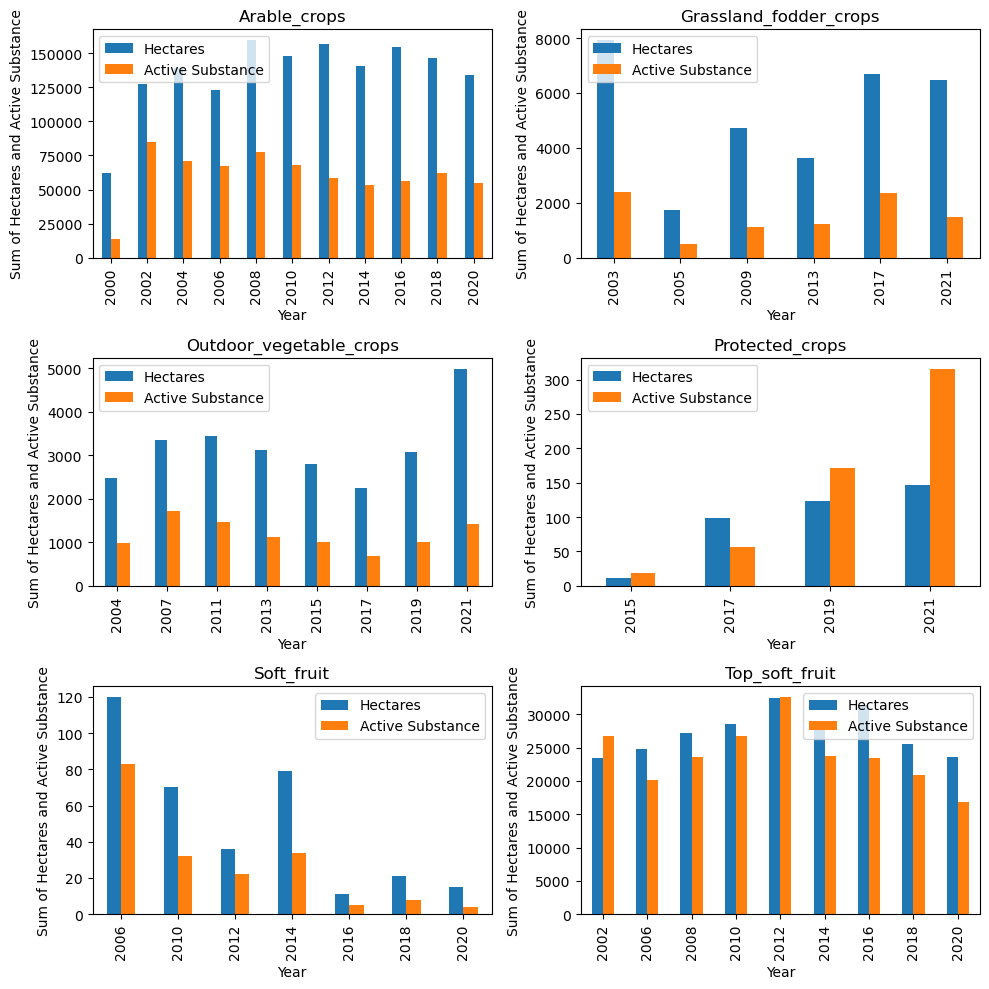

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
if not os.path.exists('IRoutput_plots'):
    os.makedirs('IRoutput_plots')

# Create a figure with a 3x2 grid of subplots

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))


# Read xlsx files from directory
# 变量I的作用是绘图的时候确定图片绘制在哪个位置
for i, filename in enumerate(os.listdir('temp_data_IR')):
    if filename.endswith('.xlsx'):
        df = pd.read_excel(os.path.join('temp_data_IR', filename))

        # Group the data by 'Year', calculate the sum of 'Hectares' and 'Active Substance'
        # 使用 Pandas 中的 groupby 方法，对 DataFrame 进行按照 'Year' 列的数值进行分组，然后使用 agg 
        # 方法进行聚合。聚合的规则是对 'Hectares' 列进行求和（'sum'）并对 'Active Substance' 列也进行求和
        # 最终得到一个按照 'Year' 列分组的 DataFrame
        grouped_data = df.groupby('Year').agg({'Hectares': 'sum', 'Active Substance': 'sum'})

        # Plot data on the i-th subplot
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        grouped_data.plot(kind='bar', ax=ax)
        #kind='bar': 这表示要绘制柱状图。指定 kind='bar' 会告诉 plot 方法绘制柱状图而不是其他类型的图表（例如线图、散点图等）
        #ax=ax: 这表示将绘图放置在指定的坐标轴（Axes）上。在这个例子中，ax 是当前子图对象，它是通过 axs[row, col] 获取的

        ax.set_xlabel('Year')
        ax.set_ylabel('Sum of Hectares and Active Substance')

        # Remove the file extension to use as the plot title
        #这部分代码用于设置每个子图的标题，标题的内容是从文件名中提取的
        plot_title = filename.rsplit('.', 1)[0]
        ax.set_title(plot_title)
        # 在图表上添加图例
        ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot to a file
plot_filename = os.path.join('IRoutput_plots', 'subplot_IR.png')
plt.savefig(plot_filename,  dpi=1000)

plt.show()

Crop Type  Arable_crops  Grassland_fodder_crops  Outdoor_vegetable_crops  Protected_crops  Soft_fruit  Top_soft_fruit
Year                                                                                                                 
2000            62382.0                     NaN                      NaN              NaN         NaN             NaN
2002           127351.0                     NaN                      NaN              NaN         NaN         23451.0
2003                NaN                  7925.0                      NaN              NaN         NaN             NaN
2004           139002.0                     NaN                   2469.0              NaN         NaN             NaN
2005                NaN                  1725.0                      NaN              NaN         NaN             NaN
2006           123128.0                     NaN                      NaN              NaN       120.0         24803.0
2007                NaN                     NaN         

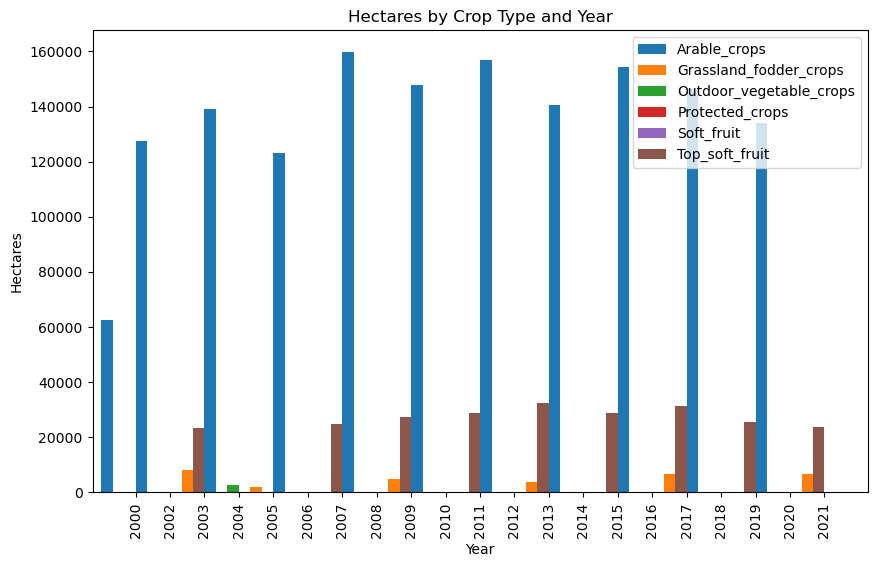

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
if not os.path.exists('IRoutput_plots'):
    os.makedirs('IRoutput_plots')

# Read xlsx files from directory
dfs = []
for filename in os.listdir('temp_data_IR'):
    if filename.endswith('.xlsx'):
        df = pd.read_excel(os.path.join('temp_data_IR', filename))
        dfs.append(df)

# Concatenate all dataframes into one
df = pd.concat(dfs)

# Group the data by 'Year' and 'Crop Type', calculate the sum of 'Hectares' and 'Active Substance'
# 提取有用数据
grouped_data = df.groupby(['Year', 'Crop Type']).agg({'Hectares': 'sum', 'Active Substance': 'sum'})

# Pivot the data to get Hectares for each year and crop type
# 对提取的数据进行数据结构的变化
# 对一个 DataFrame 进行透视表操作
# pivot_table 将其按照 'Year' 列和 'Crop Type' 列的值进行透视，生成一个新的 DataFrame pivoted_data
pivoted_data = grouped_data.pivot_table(index='Year', columns='Crop Type', values='Hectares')
#print(pivoted_data.to_string())
# Shift the first two columns one unit to the right
pivoted_data.iloc[:, 0:2] = pivoted_data.iloc[:, 0:2].shift(periods=1, axis=0)
# 本行代码存在的意义是方便绘图，使图像结果更加美观可读性强
#print(pivoted_data.to_string())

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Define a custom color map
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot data on the axis object
pivoted_data.plot(kind='bar', ax=ax, width=2, color=colors)

# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Hectares')
ax.set_title('Hectares by Crop Type and Year')

# Add a legend to the plot
ax.legend()

# Save the plot to a file
plot_filename = os.path.join('IRoutput_plots', 'hectares_IR.png')
plt.savefig(plot_filename)

plt.show()

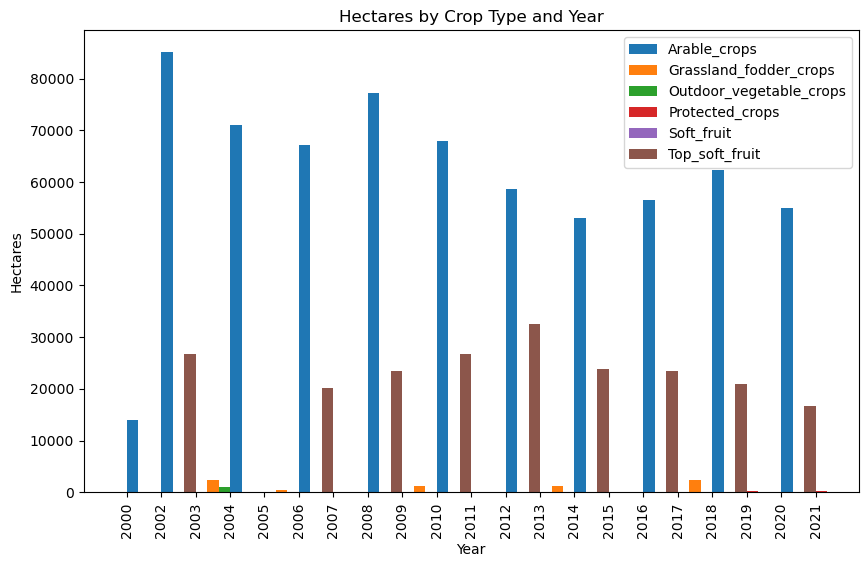

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
if not os.path.exists('IRoutput_plots'):
    os.makedirs('IRoutput_plots')

# Read xlsx files from directory
dfs = []
for filename in os.listdir('temp_data_IR'):
    if filename.endswith('.xlsx'):
        df = pd.read_excel(os.path.join('temp_data_IR', filename))
        dfs.append(df)

# Concatenate all dataframes into one
df = pd.concat(dfs)

# Group the data by 'Year' and 'Crop Type', calculate the sum of 'Hectares' and 'Active Substance'
grouped_data = df.groupby(['Year', 'Crop Type']).agg({'Hectares': 'sum', 'Active Substance': 'sum'})

# Pivot the data to get Hectares for each year and crop type
pivoted_data = grouped_data.pivot_table(index='Year', columns='Crop Type', values='Active Substance')
# index='Year' 表示 'Year' 列的唯一值将成为新 DataFrame 的行索引
#columns='Crop Type' 表示 'Crop Type' 列的唯一值将成为新 DataFrame 的列索引
#values='Active Substance' 表示 'Active Substance' 列的值将填充到新 DataFrame 的单元格中

# Shift the first two columns one unit to the right
pivoted_data.iloc[:, 0:2] = pivoted_data.iloc[:, 0:2].shift(periods=1, axis=0)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Define a custom color map
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Plot data on the axis object
pivoted_data.plot(kind='bar', ax=ax, width=2, color=colors)

# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Hectares')
ax.set_title('Hectares by Crop Type and Year')

# Add a legend to the plot
ax.legend()

# Save the plot to a file
plot_filename = os.path.join('IRoutput_plots', 'Active Substance_IR.png')
plt.savefig(plot_filename)

plt.show()



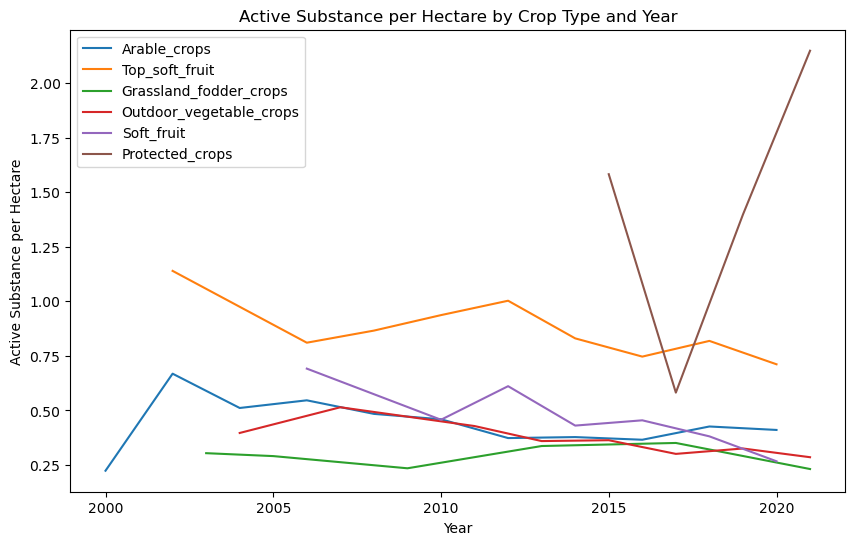

In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
if not os.path.exists('IRoutput_plots'):
    os.makedirs('IRoutput_plots')

# Read xlsx files from directory
dfs = []
for filename in os.listdir('temp_data_IR'):
    if filename.endswith('.xlsx'):
        df = pd.read_excel(os.path.join('temp_data_IR', filename))
        dfs.append(df)

# Concatenate all dataframes into one
df = pd.concat(dfs)

# Group the data by 'Year' and 'Crop Type', calculate the sum of 'Active Substance' and 'Hectares'
grouped_data = df.groupby(['Year', 'Crop Type']).agg({'Hectares': 'sum', 'Active Substance': 'sum'})
#print(grouped_data.to_string())

# Calculate Active Substance per Hectare
grouped_data['Active Substance per Hectare'] = grouped_data['Active Substance'] / grouped_data['Hectares']
#print(grouped_data.to_string())

# Reset the index of the dataframe
grouped_data = grouped_data.reset_index()
#索引重置的作用相当于补充一些原先没有的数据，组成单个行的数据行，再方便作图

#print(grouped_data.to_string())

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Use seaborn to plot the data
sns.lineplot(data=grouped_data, x='Year', y='Active Substance per Hectare', hue='Crop Type', ax=ax)

# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Active Substance per Hectare')
ax.set_title('Active Substance per Hectare by Crop Type and Year')

# Add a legend to the plot
ax.legend()

# Save the plot to a file
plot_filename = os.path.join('IRoutput_plots', 'active_substance_per_hectare_IR.png')
plt.savefig(plot_filename)

plt.show()

Fungicide
*Sulphur                     2002
Ametoctradin/Dimethomorph    2012
Ametoctradin/dimethomorph    2016
Amisulbrom                   2020
Azoxystrobin                 2000
                             ... 
Tridemorph                   2000
Trifloxystrobin              2000
Unknownfungicide             2002
Vinclozolin                  2002
Zineb                        2004
Name: Year, Length: 216, dtype: int64
Fungicide
*Sulphur                     2002
Ametoctradin/Dimethomorph    2014
Ametoctradin/dimethomorph    2020
Amisulbrom                   2020
Azoxystrobin                 2021
                             ... 
Tridemorph                   2002
Trifloxystrobin              2020
Unknownfungicide             2021
Vinclozolin                  2002
Zineb                        2004
Name: Year, Length: 216, dtype: int64
                      Hectares
Fungicide       Year          
Azoxystrobin    2000    9535.0
                2002    8446.0
                2003     652.0
 

KeyboardInterrupt: 

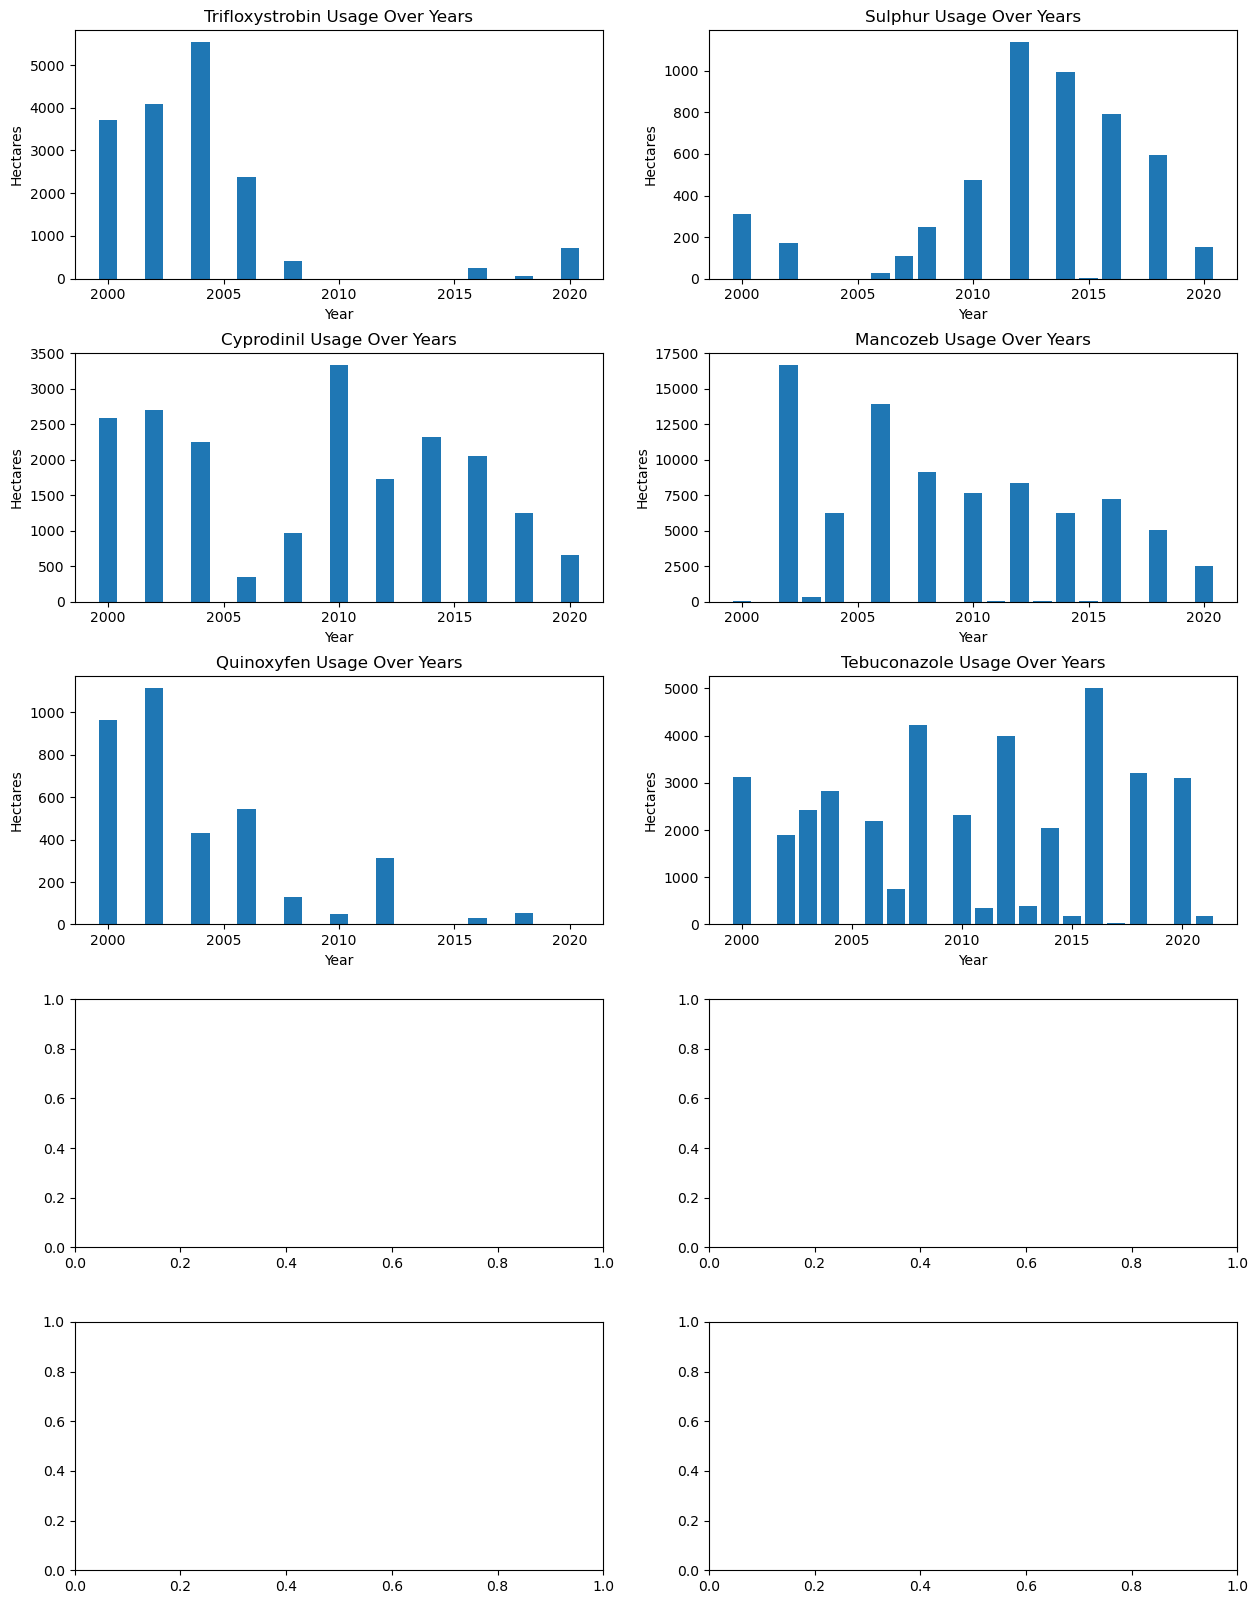

In [26]:
# 统计每个Fungicide值第一次出现的年份
print(df.groupby("Fungicide")["Year"].min())

# 统计每个Fungicide值最后一次出现的年份
print(df.groupby("Fungicide")["Year"].max())

# 将结果保存到csv文件中
min_year = df.groupby("Fungicide")["Year"].min()
#print(min_year)
max_year = df.groupby("Fungicide")["Year"].max()
result = pd.concat([min_year, max_year], axis=1)
result.columns = ["First Year", "Last Year"]
result.to_excel("temp_data_IR/year_range.xlsx")

# 按照杀菌剂使用的时间长短（last year - first year），进行排序
result["Year Range"] = result["Last Year"] - result["First Year"]
result.sort_values(by="Year Range", inplace=True)
#print(result)
result.to_excel("output/year_range.xlsx")

top_10 = result.tail(10)
top_10_fungicides = top_10.index.tolist()
#print(top_10_fungicides)

# 从df中提取出top_10_fungicides的数据
top_10_df = df[df["Fungicide"].isin(top_10_fungicides)] 
#print(top_10_df)


# 按照Fungicide和Year进行分组，计算Hectares的和
top_10_df = top_10_df.groupby(["Fungicide", "Year"]).agg({"Hectares": "sum"}) 
print(top_10_df)

# 将top_10_df中的Fungicide和Year转换为列
# 和上面一样，就是一个简单的数据填充
top_10_df.reset_index(inplace=True) 
print(top_10_df)


# 将top_10_df中的Fungicide的值作为列名，Hectares的值作为对应的值
top_10_df = top_10_df.pivot(index="Year", columns="Fungicide", values="Hectares")
#print(top_10_df)

# Create a figure and axis object
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.subplots_adjust(hspace=0.3)

# Loop through the top 10 fungicides and plot each one on a separate axis
for i, fungicide in enumerate(top_10_fungicides):
    # Calculate the row and column index for the current axis
    row = i // 2
    col = i % 2

    # Extract the data for the current fungicide
    fungicide_df = top_10_df[fungicide]

    # Plot the data on the current axis
    axs[row, col].bar(fungicide_df.index, fungicide_df.values)
    axs[row, col].set_xlabel('Year')
    axs[row, col].set_ylabel('Hectares')
    axs[row, col].set_title(f'{fungicide} Usage Over Years')
    axs[row, col].tick_params(axis='x')

    # Save the plot to a file
    plot_filename = os.path.join('output', 'top10.png')
    plt.savefig(plot_filename, dpi=1000)

# Show the plot
plt.show()

Arable_crops.xlsx Year
2000    42
2002    56
2004    51
2006    55
2008    60
2010    59
2012    67
2014    63
2016    67
2018    64
2020    68
Name: Fungicide, dtype: int64
Grassland_fodder_crops.xlsx Year
2003    12
2005     7
2009    16
2013    19
2017    22
2021    22
Name: Fungicide, dtype: int64
Outdoor_vegetable_crops.xlsx Year
2004    22
2007    19
2011    22
2013    24
2015    21
2017    18
2019    16
2021    14
Name: Fungicide, dtype: int64
Protected_crops.xlsx Year
2015     7
2017    12
2019    14
2021    11
Name: Fungicide, dtype: int64
Soft_fruit.xlsx Year
2006    19
2010    18
2012    21
2014    21
2016    11
2018    14
2020    11
Name: Fungicide, dtype: int64
Top_soft_fruit.xlsx Year
2002    19
2006    16
2008    20
2010    19
2012    18
2014    17
2016    19
2018    23
2020    23
Name: Fungicide, dtype: int64


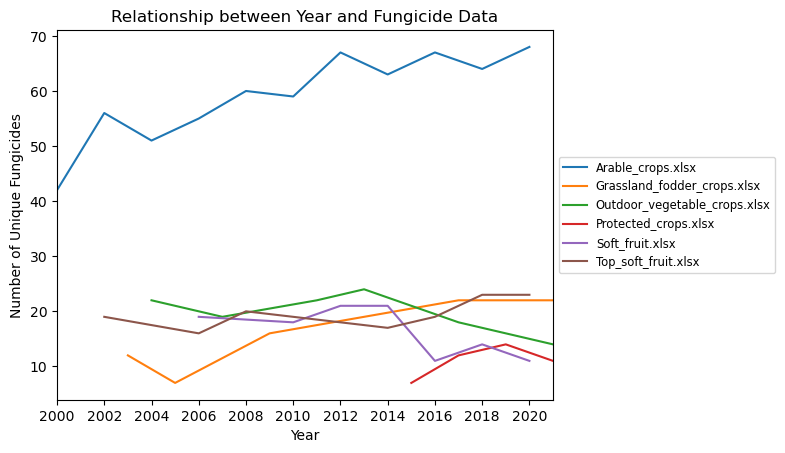

In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 创建一个空的DataFrame 
df = pd.DataFrame()

# 循环读取temp_data目录下的所有xlsx文件
for filename in os.listdir('temp_data_IR'):
    if filename.endswith('.xlsx'):
        # 读取文件
        data = pd.read_excel(os.path.join('temp_data_IR', filename))

        # 将年份转换为整数类型
        data['Year'] = data['Year'].astype(int)

        # 计算每年使用的杀菌剂的种类数量
        data = data.groupby('Year')['Fungicide'].nunique()
        # nunique 计算所有唯一值的数量
        print(filename, data)
        # Create a line plot
        data.plot(kind='line', label=filename)

plt.xlabel('Year')
plt.ylabel('Number of Unique Fungicides')
plt.title('Relationship between Year and Fungicide Data')
plt.legend(fontsize='small', loc='center left', bbox_to_anchor=(1, 0.5))
# Set x-axis limits
plt.xlim(2000, 2021)
plt.xticks(range(2000, 2022, 2))
plt.savefig('output/relationship_between_year_and_fungicide_data.png', dpi=1000, bbox_inches='tight')
plt.show()

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 读取数据
df = pd.read_excel("D:\\ML-all\\IrelandFungicideDataAnalysis\\temp_data_IR\\temp_data_IR\\Arable_crops.xlsx")

# 按年份分组，计算Hectares和Active Substance的总和
grouped_data = df.groupby('Year').agg({'Hectares': 'sum', 'Active Substance': 'sum'})
print(grouped_data)
# 使用时间序列模型判断Hectares的值是否存在趋势
model = ARIMA(grouped_data['Hectares'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# 使用时间序列模型判断Active Substance的值是否存在趋势
model = ARIMA(grouped_data['Active Substance'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

      Hectares  Active Substance
Year                            
2000     62382           13934.0
2002    127351           85122.0
2004    139002           71046.2
2006    123128           67259.1
2008    159730           77315.2
2010    147788           67885.0
2012    157045           58593.0
2014    140604           53100.0
2016    154516           56470.0
2018    146345           62380.1
2020    134007           54995.1
                               SARIMAX Results                                
Dep. Variable:               Hectares   No. Observations:                   11
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -115.090
Date:                Fri, 24 Nov 2023   AIC                            236.180
Time:                        13:23:38   BIC                            237.088
Sample:                             0   HQIC                           235.184
                                 - 11                                         
Covariance Type:  

d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\anaconda\Lib\site

F-value: 5.262579189519836
P-value: 9.052684221973253e-08


d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26432 (\N{CJK UNIFIED IDEOGRAPH-6740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 33740 (\N{CJK UNIFIED IDEOGRAPH-83CC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21058 (\N{CJK UNIFIED IDEOGRAPH-5242}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20351 (\N{CJK UNIFIED IDEOGRAPH-4F7F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\Lib\site-packages\IPython\core\pylabtools.p

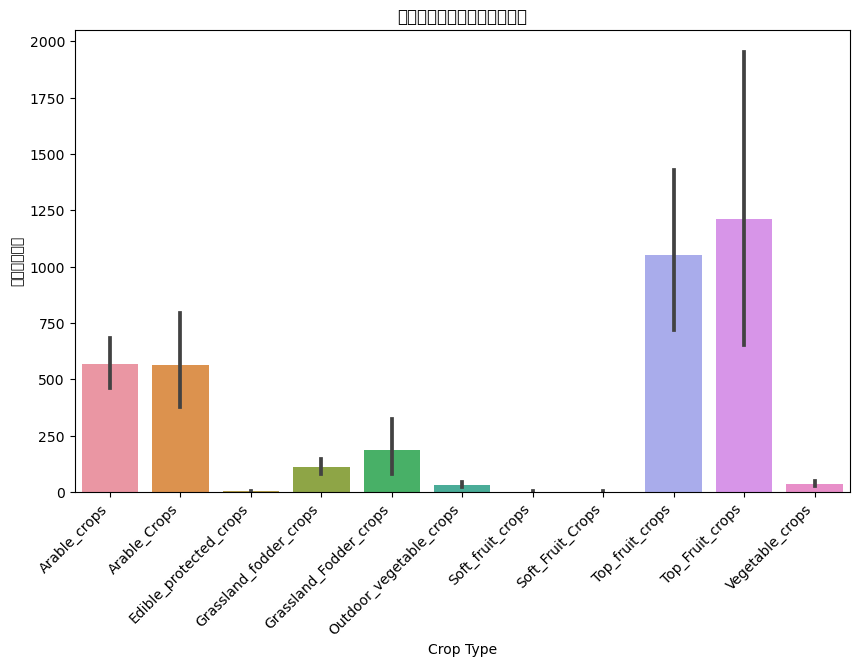

In [47]:
import pandas as pd
import scipy.stats as stats
df=pd.read_excel("output/resultIR.xlsx")

# 假设 df 是一个 DataFrame，其中 "Crop Type" 是作物类型， "Hectares" 是每公顷的杀菌剂使用量
# 使用 pandas 的 groupby 方法，根据作物类型将数据分组
groups = df.groupby("Crop Type").groups
unique_crop_types = df["Crop Type"].unique()
 

# 将每一组作物的杀菌剂使用量收集起来
hectares_used = [df.loc[groups[name], "Hectares"] for name in groups]

# 进行 ANOVA 分析
f_value, p_value = stats.f_oneway(*hectares_used)

print("F-value:", f_value)
print("P-value:", p_value)
plt.figure(figsize=(10, 6))
sns.barplot(x="Crop Type", y="Hectares", data=df)
plt.xticks(rotation=45, ha='right')
plt.title('不同作物类型的杀菌剂使用量')
plt.ylabel('杀菌剂使用量')
plt.show()


In [36]:
# 画一个神经网络模型
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 读取数据
